In [11]:
from __future__ import division
import os

import numpy as np
from numpy import pi

import pandas as pd
from numpy import sqrt
from scipy import integrate

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def journal():
    '''
    Appears nearly square. I like this best.
    'figure.figsize': [3.1, 2.6]
    
    Use: plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
    plt.xlabel('$E_{iso}$ $(erg)$',labelpad=-1)  
    plt.ylabel('$E^*_{pk}$ $(keV)$',labelpad=-2)
    
    '''
    params = {'backend': 'pdf',
              'axes.labelsize':  10,
              'font.size':       10,
              'legend.fontsize': 8,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'text.usetex':     True,
              'figure.figsize': [4,3], #[4,3], #[3.1, 2.6], # [7,6]
              'font.family': 'serif',}
    plt.rcParams.update(params)

In [13]:
journal()

#### All luminosity distance functions must pass results in parsecs.

In [14]:
def LumDist_concordance(redshift, H_knot, omega_m):
    """
    This is the function we use in our work, but different cosmo constants 
    as well as DL units. 
    """
    z           = redshift
    omega_l     = 1.0 - omega_m
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    def Aint(z):
        return (1./(sqrt(((1.+z)*(1.+z)*(1. + omega_m * z))-(z*(2.+ z)*omega_l ))))
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_riess(redshift, H_knot, omega_m):
    """
    Lower order expansion for dark energy term (w). Equation 14 in Riess et al. 2004. 
    w(z) = w0 + w'z
    """
    z           = redshift
    omega_l     = 1.0 - omega_m
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    w0 = -1.31
    wp = 1.48   # p: prime symbol
    def Aint(z):
        return 1./np.sqrt( ((1.+z)**3)*omega_m + \
                         omega_l*((1.+z)**(3*(1+w0-wp)))*np.exp(3*wp*z) )
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_weylgravity(redshift, H_knot):
    """
    Weyl Gravity.
    Equation 237 in Mannheim 2006 paper
    q_knot      = -0.37 or -0.2
    """
    z           = redshift
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    q_knot      = -0.37
    DL_Mpc  = (-c * ((1. + z)**2) / (H_knot * q_knot)) * \
                (1-np.sqrt(1 + q_knot - (q_knot/((1+z)**2))))
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc

    
def distance_modulus(lumdistance):
    return 5*np.log10(lumdistance)-5


def get_moduli(model, redshifts=None, H_knot=None, omega_m=None):
    """
    model : str. 'concord', 'weyl', or 'riess'
                    or 'c', 'w', and 'r'
    
    """
    H0 = H_knot
    OM = omega_m
    if model.startswith('c'):   
        DLs = [LumDist_concordance(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('r'):   
        DLs = [LumDist_riess(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('w'):   
        DLs = [LumDist_weylgravity(redshift=z, H_knot=H0) for z in redshifts]
    moduli = [distance_modulus(lumdistance=dL) for dL in DLs]
    return moduli

In [15]:
def calc_eiso(fluence, lumdist, redshift):
    flue = fluence
    DL = lumdist 
    z = redshift
    return flue*((4.0*pi*(DL**2))/(1.0+z))

In [16]:
mu = lambda values,errors: np.nansum([i/(j**2) for i,j in zip(values,errors)])/np.nansum([(j**-2.) for j in errors])
mu_unc = lambda errors: (np.nansum([(j**-2.) for j in errors]))**-0.5

Read Data
---

In [17]:
filename = ('/Users/KimiZ/GRBs2/Sample/'
            'Band_13_GBM+LAT__22_GBMconstrained.txt')

df_ = pd.read_csv(filename, sep='\t')

In [18]:
cols2keep = ['trigger', 'name', 'number', 'z', 't90', 'detector','LATburst'] 

# Make new dataframe with only certain columns
df = pd.DataFrame(df_.loc[:, cols2keep])

# Copy over flux and fluences from 1 keV-10 MeV. 
df['flux'] = df_['Flux3']
df['flux_err_low'] = df_['Flux3']-df_['Flux3_err']  # value - margin of error
df['flux_err_up'] = df_['Flux3']+df_['Flux3_err']   # value + margin of error


df['fluence'] = df_['Flue3']
df['fluence_err_low'] = df_['Flue3']-df_['Flue3_err']  # value - margin of error
df['fluence_err_up'] = df_['Flue3']+df_['Flue3_err']   # value + margin of error

In [19]:
#   The luminosity distances of these functions are in parsecs. Need to use pctocm to convert to cm.
# 1 pc = 3.0856775814914E+18 cm
Mpctocm = 3.08567758E24
pctocm = 3.08567758E18

In [20]:
H_knot = 65.
omega_m = 0.3

redshifts = df.z.values

In [21]:
# Concordance Cosmology (Lambda CDM)
df['DL1'] = np.asarray([LumDist_concordance(redshift=z, H_knot=H_knot, omega_m=omega_m) for z in redshifts])*pctocm

# Riess Cosmology
df['DL2'] = np.asarray([LumDist_riess(redshift=z, H_knot=H_knot, omega_m=omega_m) for z in redshifts])*pctocm

# Weyl Gravity
df['DL3'] = np.asarray([LumDist_weylgravity(redshift=z, H_knot=H_knot) for z in redshifts])*pctocm

In [22]:
# Concordance Cosmology (Lambda CDM)
df['eiso1']         = calc_eiso(fluence=df.fluence, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err']     = df['eiso1']-df['eiso1_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged

# Riess Cosmology
df['eiso2']         = calc_eiso(fluence=df.fluence, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err']     = df['eiso2']-df['eiso2_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged

# Weyl Gravity
df['eiso3']         = calc_eiso(fluence=df.fluence, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err']     = df['eiso3']-df['eiso3_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged


In [23]:
df.head()

,trigger,name,number,z,t90,detector,LATburst,flux,flux_err_low,flux_err_up,...,eiso1_err_up,eiso1_err,eiso2,eiso2_err_low,eiso2_err_up,eiso2_err,eiso3,eiso3_err_low,eiso3_err_up,eiso3_err
0,bn080916009,080916C,5,4.350,62.977,L,Y,0.000002,0.000001,0.000002,...,3.945909e+54,7.854279e+52,2.085139e+54,2.042791e+54,2.127486e+54,4.234732e+52,1.063322e+55,1.041727e+55,1.084917e+55,2.159514e+53
1,bn090323002,90323,13,3.570,135.170,L,Y,0.000001,0.000001,0.000001,...,4.683611e+54,1.014428e+53,2.831916e+54,2.769221e+54,2.894611e+54,6.269468e+52,1.040441e+55,1.017407e+55,1.063475e+55,2.303391e+53
2,bn090328401,090328A,14,0.736,61.697,L,Y,0.000001,0.000001,0.000001,...,1.342025e+53,3.755056e+51,1.312229e+53,1.274455e+53,1.350003e+53,3.777378e+51,1.355780e+53,1.316752e+53,1.394807e+53,3.902743e+51
3,bn090510016,90510,17,0.903,0.960,L,Y,0.000013,0.000012,0.000014,...,3.274935e+52,2.129352e+51,3.017723e+52,2.807867e+52,3.227579e+52,2.098561e+51,3.302881e+52,3.073194e+52,3.532567e+52,2.296863e+51
4,bn090902462,090902B,20,1.822,19.328,L,Y,0.000020,0.000020,0.000021,...,3.766009e+54,2.901089e+52,3.230757e+54,3.205676e+54,3.255838e+54,2.508086e+52,5.208504e+54,5.168070e+54,5.248939e+54,4.043441e+52


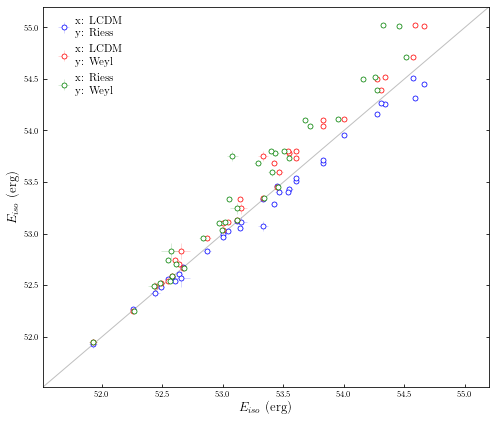

In [24]:
axLims = (51.51, 55.2)


plt.clf()
plt.figure(figsize=(8,7))
#plt.figure()


xaxis = 'eiso1'
yaxis = 'eiso2'
pltKwgs = dict(fmt='o', color='white', ecolor='blue', ms=5, lw=0.6, mec='blue', mew=0.75,
               capsize=0, alpha=1, label='x: LCDM\ny: Riess')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]


xaxis = 'eiso1'
yaxis = 'eiso3'
pltKwgs = dict(fmt='o', color='white', ecolor='red', ms=5, lw=0.6, mec='red', mew=0.75,
               capsize=0, alpha=1, label='x: LCDM\ny: Weyl')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]
    

xaxis = 'eiso2'
yaxis = 'eiso3'
pltKwgs = dict(fmt='o', color='white', ecolor='green', ms=5, lw=0.6, mec='green', mew=0.75,
               capsize=0, alpha=1, label='x: Riess\ny: Weyl')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]
#[marker.set_alpha(0.25) for marker in markers]


# Plot a line at equal values of x and y 
xlinedata = np.linspace(axLims[0], axLims[1], 10)
ylinedata = 1.0*xlinedata+0
plt.plot(xlinedata, ylinedata, 'k-', lw=1, alpha=0.25) 

plt.xlim(*axLims)
plt.ylim(*axLims)
plt.legend(loc=0, fontsize=11, labelspacing=0.7, handletextpad=0, frameon=False)
plt.xlabel('$E_{iso}$ (erg)', fontsize=13)
plt.ylabel('$E_{iso}$ (erg)', fontsize=13)
plt.show()


In [25]:
df['diff_1v2'] = (df['eiso1'].apply(np.log10) - df['eiso2'].apply(np.log10)).apply(abs)

df['diff_1v3'] = (df['eiso1'].apply(np.log10) - df['eiso3'].apply(np.log10)).apply(abs)

df['diff_2v3'] = (df['eiso2'].apply(np.log10) - df['eiso3'].apply(np.log10)).apply(abs)

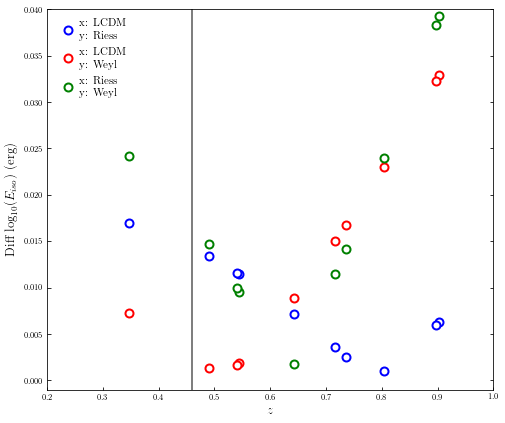

In [26]:
xLims = (None, None)
yLims = (None, None)

xLims = (0.2, 1)
yLims = (-0.001, .04)


plt.clf()
plt.figure(figsize=(8,7))
#plt.figure()

plt.plot(df['z'], df['diff_1v2'], marker='o', ms=8, color='white', mec='blue', mew=2, lw=0,  label='x: LCDM\ny: Riess')

plt.plot(df['z'], df['diff_1v3'], marker='o', ms=8, color='white', mec='red', mew=2, lw=0, label='x: LCDM\ny: Weyl')

plt.plot(df['z'], df['diff_2v3'], marker='o', ms=8, color='white', mec='green', mew=2, lw=0, label='x: Riess\ny: Weyl')

plt.axvline(0.46, 0, 1, color='k', lw=2, alpha=0.5)

plt.xlim(*xLims)
plt.ylim(*yLims)
plt.legend(loc=0, fontsize=11, labelspacing=0.7, handletextpad=0, frameon=False)
plt.ylabel('Diff $\log_{10}$($E_{iso}$) (erg)', fontsize=13)
plt.xlabel('$z$', fontsize=13)
plt.show()

In [50]:
sort_by = 'diff_1v2'

kim = df.sort_values(by=sort_by).loc[:, ['z',sort_by]]

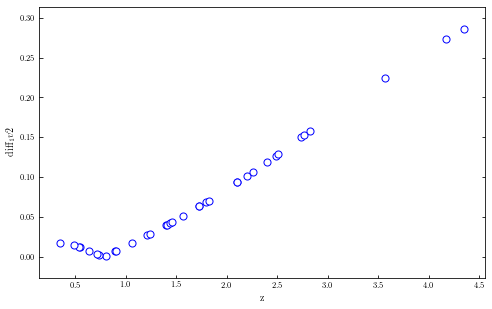

In [51]:
plt.clf()
(kim).plot(kind='scatter', x='z', y=sort_by, figsize=(8,5),
                                                        marker='o', s=50, color='white', edgecolor='blue')

In [52]:
kim.min()

z           0.347000
diff_1v2    0.001522
dtype: float64

In [53]:
kim

,z,diff_1v2
23,0.8040,0.001522
2,0.7360,0.002385
26,0.7160,0.003498
6,0.8969,0.007092
12,0.6420,0.007444
3,0.9030,0.007465
16,0.5440,0.012100
17,0.5400,0.012272
19,0.4900,0.014280
7,1.0633,0.017528


In [54]:
df.sort_values(by='z').loc[:, ['z', 'number', 'LATburst']]

,z,number,LATburst
32,0.3470,62,N
19,0.4900,27,N
17,0.5400,19,N
16,0.5440,16,N
12,0.6420,66,Y
26,0.7160,45,N
2,0.7360,14,Y
23,0.8040,36,N
6,0.8969,24,Y
3,0.9030,17,Y


In [69]:
sort_by = 'diff_1v3'

kim2 = df.sort_values(by=sort_by).loc[:, ['z',sort_by]]

In [70]:
plt.clf()

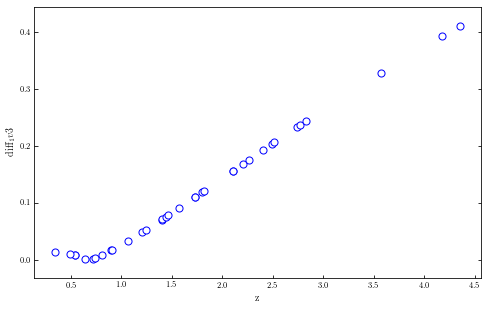

In [71]:
(kim2).plot(kind='scatter', x='z', y=sort_by, figsize=(8,5),
                                                        marker='o', s=50, color='white', edgecolor='blue')

In [72]:
kim2.min()

z           0.347000
diff_1v3    0.002457
dtype: float64

In [73]:
kim2

,z,diff_1v3
12,0.6420,0.002457
26,0.7160,0.002592
2,0.7360,0.004074
16,0.5440,0.007952
17,0.5400,0.008144
23,0.8040,0.009450
19,0.4900,0.010313
32,0.3470,0.013836
6,0.8969,0.017541
3,0.9030,0.018099


In [74]:
df.sort_values(by='z').loc[:, ['z', 'number', 'LATburst']]

,z,number,LATburst
32,0.3470,62,N
19,0.4900,27,N
17,0.5400,19,N
16,0.5440,16,N
12,0.6420,66,Y
26,0.7160,45,N
2,0.7360,14,Y
23,0.8040,36,N
6,0.8969,24,Y
3,0.9030,17,Y


In [75]:
sort_by = 'diff_2v3'

kim3 = df.sort_values(by=sort_by).loc[:, ['z',sort_by]]

In [76]:
plt.clf()

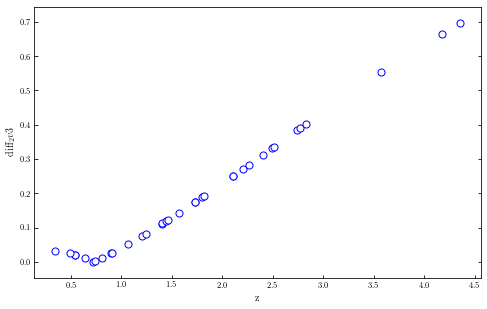

In [77]:
(kim3).plot(kind='scatter', x='z', y=sort_by, figsize=(8,5),
                                                        marker='o', s=50, color='white', edgecolor='blue')

In [78]:
kim3.min()

z           0.347000
diff_2v3    0.000907
dtype: float64

In [79]:
kim3

,z,diff_2v3
26,0.7160,0.000907
2,0.7360,0.001689
12,0.6420,0.009901
23,0.8040,0.010972
16,0.5440,0.020052
17,0.5400,0.020416
19,0.4900,0.024593
6,0.8969,0.024633
3,0.9030,0.025565
32,0.3470,0.031848


In [80]:
df.sort_values(by='z').loc[:, ['z', 'number', 'LATburst']]

,z,number,LATburst
32,0.3470,62,N
19,0.4900,27,N
17,0.5400,19,N
16,0.5440,16,N
12,0.6420,66,Y
26,0.7160,45,N
2,0.7360,14,Y
23,0.8040,36,N
6,0.8969,24,Y
3,0.9030,17,Y


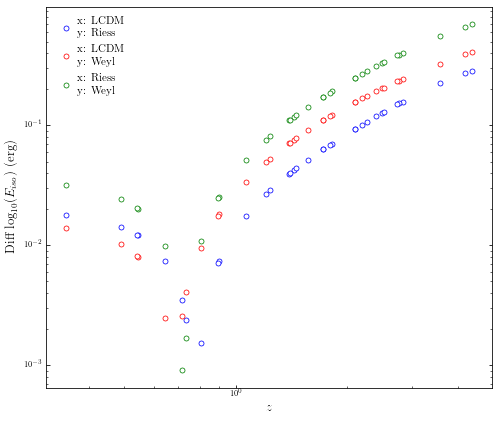

In [81]:
#axLims = (51.51, 55.2)


plt.clf()
plt.figure(figsize=(8,7))
#plt.figure()

pltKwgs = dict(fmt='o', color='white', ecolor='blue', ms=5, lw=0.6, mec='blue', mew=0.75,
               capsize=0, alpha=1, label='x: LCDM\ny: Riess')
plt.errorbar(x=df['z'], y=df['diff_1v2'], **pltKwgs)


pltKwgs = dict(fmt='o', color='white', ecolor='red', ms=5, lw=0.6, mec='red', mew=0.75,
               capsize=0, alpha=1, label='x: LCDM\ny: Weyl')
plt.errorbar(x=df['z'], y=df['diff_1v3'], **pltKwgs)


pltKwgs = dict(fmt='o', color='white', ecolor='green', ms=5, lw=0.6, mec='green', mew=0.75,
               capsize=0, alpha=1, label='x: Riess\ny: Weyl')
plt.errorbar(x=df['z'], y=df['diff_2v3'], **pltKwgs)


# plt.xlim(*axLims)
# plt.ylim(*axLims)
plt.legend(loc=0, fontsize=11, labelspacing=0.7, handletextpad=0, frameon=False)
plt.ylabel('Diff $\log_{10}$($E_{iso}$) (erg)', fontsize=13)
plt.xlabel('$z$', fontsize=13)
plt.yscale('log')
plt.xscale('log')
plt.show()

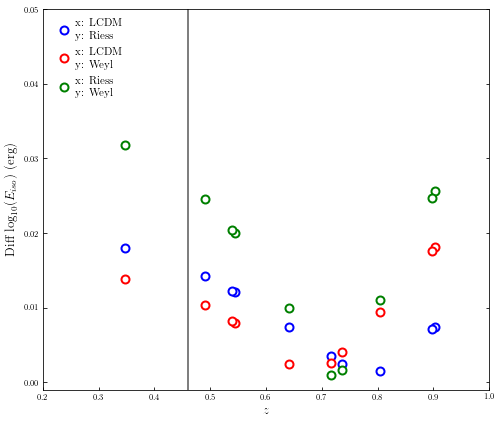

In [85]:
xLims = (None, None)
yLims = (None, None)

xLims = (0.2, 1)
yLims = (-0.001, .05)


plt.clf()
plt.figure(figsize=(8,7))
#plt.figure()

plt.plot(df['z'], df['diff_1v2'], marker='o', ms=8, color='white', mec='blue', mew=2, lw=0,  label='x: LCDM\ny: Riess')

plt.plot(df['z'], df['diff_1v3'], marker='o', ms=8, color='white', mec='red', mew=2, lw=0, label='x: LCDM\ny: Weyl')

plt.plot(df['z'], df['diff_2v3'], marker='o', ms=8, color='white', mec='green', mew=2, lw=0, label='x: Riess\ny: Weyl')

plt.axvline(0.46, 0, 1, color='k', lw=2, alpha=0.5)

plt.xlim(*xLims)
plt.ylim(*yLims)
plt.legend(loc=0, fontsize=11, labelspacing=0.7, handletextpad=0, frameon=False)
plt.ylabel('Diff $\log_{10}$($E_{iso}$) (erg)', fontsize=13)
plt.xlabel('$z$', fontsize=13)
plt.show()